In [1]:
import pandas as pd
import rdkit
from rdkit import Chem
from sklearn.model_selection import train_test_split


In [2]:
import pandas as pd
df = pd.read_csv("../chembl.csv", sep=';')
columns = ['Molecule ChEMBL ID', 'Smiles', 'pChEMBL Value']
df = df[columns]
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)


def activity(value):
  if value >= 6.5:
    return 1
  else:
    return 0



df['activity'] = df['pChEMBL Value'].apply(activity)
print(df['activity'].value_counts())


from sklearn.utils import resample

# Separate the data into active and inactive classes
active = df[df['activity'] == 0]
inactive = df[df['activity'] == 1]

# Oversample the active class to match the inactive class count
active_oversampled = resample(active,
                              replace=True,             # Allow replacement for oversampling
                              n_samples=len(inactive),  # Match the inactive class count
                              random_state=42)          # Seed for reproducibility

# Combine the oversampled active class with the inactive class
oversampled_data = pd.concat([active_oversampled, inactive])

# Shuffle the dataset
oversampled_data = oversampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

print(oversampled_data['activity'].value_counts())
oversampled_data.to_csv("classification.csv")

activity
1    614
0    461
Name: count, dtype: int64
activity
1    614
0    614
Name: count, dtype: int64


In [3]:
df

,Molecule ChEMBL ID,Smiles,pChEMBL Value,activity
0,CHEMBL204984,CC(C)(C)c1ccc(Nc2nnc(-c3ccncc3CCc3ccncc3)o2)cc1,6.66,1
1,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,6.85,1
2,CHEMBL1095465,COc1ccc(OC)c(Cc2cc3c(Nc4cccc(Br)c4)nc(N)nc3[nH...,4.51,0
3,CHEMBL1289601,COc1cc2nccc(Oc3ccc(NC(=O)NC4CC4)c(Cl)c3)c2cc1C...,7.66,1
4,CHEMBL194911,COc1ccc(-c2oc3ncnc(N)c3c2-c2ccc(NC(=O)Nc3cc(C(...,7.81,1
...,...,...,...,...
1070,CHEMBL2220486,CNC(=O)c1cccc2cc(Oc3ccnc4cc(OCC5(N)CC5)c(OC)cc...,8.15,1
1071,CHEMBL502835,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,7.89,1
1072,CHEMBL388978,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,7.46,1
1073,CHEMBL535,CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(F...,9.00,1


In [4]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Avalon import pyAvalonTools
import numpy as np
import pandas as pd

def smiles_to_mols(smiles_list):
    mols = []
    valid_idx = []
    for i, smi in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smi)
        if mol:
            mols.append(mol)
            valid_idx.append(i)
    return mols, valid_idx

def calculate_fingerprints(df, smiles_col='Smiles', method='ecfp', radius=2, nBits=1024):
    """
    Calculates ECFP or Avalon fingerprints and returns a merged DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame with a column of SMILES strings.
        smiles_col (str): Name of the SMILES column.
        method (str): 'ecfp' or 'avalon'.
        radius (int): Radius for ECFP (ignored for Avalon).
        nBits (int): Number of bits for the fingerprint.

    Returns:
        pd.DataFrame: Original DataFrame concatenated with fingerprint bits.
    """
    smiles_list = df[smiles_col]
    mols, valid_idx = smiles_to_mols(smiles_list)
    fingerprints = []

    for mol in mols:
        if method == 'ecfp':
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
        elif method == 'avalon':
            fp = pyAvalonTools.GetAvalonFP(mol, nBits=nBits)
        else:
            raise ValueError("Method must be 'ecfp' or 'avalon'")
        
        fp_np = np.zeros((nBits,), dtype=int)
        DataStructs.ConvertToNumpyArray(fp, fp_np)
        fingerprints.append(fp_np)

    # Create DataFrame for fingerprints
    prefix = method.upper()
    fp_df = pd.DataFrame(fingerprints, columns=[f'{prefix}_{i}' for i in range(nBits)])
    fp_df.index = valid_idx

    # Keep only valid molecules
    df_valid = df.iloc[valid_idx].reset_index(drop=True)
    fp_df = fp_df.reset_index(drop=True)

    # Concatenate and return
    return pd.concat([df_valid, fp_df], axis=1)


In [5]:
df_with_ecfp = calculate_fingerprints(df, smiles_col='Smiles', method='avalon', radius=2, nBits=1024)

In [6]:
df_with_ecfp

,Molecule ChEMBL ID,Smiles,pChEMBL Value,activity,AVALON_0,AVALON_1,AVALON_2,AVALON_3,AVALON_4,AVALON_5,...,AVALON_1014,AVALON_1015,AVALON_1016,AVALON_1017,AVALON_1018,AVALON_1019,AVALON_1020,AVALON_1021,AVALON_1022,AVALON_1023
0,CHEMBL204984,CC(C)(C)c1ccc(Nc2nnc(-c3ccncc3CCc3ccncc3)o2)cc1,6.66,1,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,1
1,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,6.85,1,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,0
2,CHEMBL1095465,COc1ccc(OC)c(Cc2cc3c(Nc4cccc(Br)c4)nc(N)nc3[nH...,4.51,0,0,0,1,0,0,0,...,1,0,1,1,0,0,0,0,0,1
3,CHEMBL1289601,COc1cc2nccc(Oc3ccc(NC(=O)NC4CC4)c(Cl)c3)c2cc1C...,7.66,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,CHEMBL194911,COc1ccc(-c2oc3ncnc(N)c3c2-c2ccc(NC(=O)Nc3cc(C(...,7.81,1,0,0,1,0,1,0,...,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,CHEMBL2220486,CNC(=O)c1cccc2cc(Oc3ccnc4cc(OCC5(N)CC5)c(OC)cc...,8.15,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1071,CHEMBL502835,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,7.89,1,0,0,1,1,1,0,...,1,1,0,0,0,0,0,0,1,1
1072,CHEMBL388978,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,7.46,1,0,1,1,1,1,0,...,1,0,1,0,0,0,0,0,1,1
1073,CHEMBL535,CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(F...,9.00,1,0,0,1,1,1,1,...,1,0,1,0,0,1,1,0,0,1


In [7]:
X = df_with_ecfp.drop(columns=['Smiles', 'Molecule ChEMBL ID', 'activity','pChEMBL Value'])

In [8]:
X

,AVALON_0,AVALON_1,AVALON_2,AVALON_3,AVALON_4,AVALON_5,AVALON_6,AVALON_7,AVALON_8,AVALON_9,...,AVALON_1014,AVALON_1015,AVALON_1016,AVALON_1017,AVALON_1018,AVALON_1019,AVALON_1020,AVALON_1021,AVALON_1022,AVALON_1023
0,0,0,1,0,0,1,0,0,1,1,...,0,0,1,0,0,1,0,0,0,1
1,0,0,1,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,1,0,0,1,...,1,0,1,1,0,0,0,0,0,1
3,0,0,1,0,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,1,...,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1071,0,0,1,1,1,0,1,0,0,1,...,1,1,0,0,0,0,0,0,1,1
1072,0,1,1,1,1,0,1,0,0,0,...,1,0,1,0,0,0,0,0,1,1
1073,0,0,1,1,1,1,1,0,0,1,...,1,0,1,0,0,1,1,0,0,1


In [9]:
y = df_with_ecfp['activity']

In [10]:
y

0       1
1       1
2       0
3       1
4       1
       ..
1070    1
1071    1
1072    1
1073    1
1074    0
Name: activity, Length: 1075, dtype: int64

In [11]:
X = X.loc[:, X.nunique() > 1]

In [12]:
X

,AVALON_0,AVALON_1,AVALON_2,AVALON_3,AVALON_4,AVALON_5,AVALON_6,AVALON_7,AVALON_8,AVALON_9,...,AVALON_1014,AVALON_1015,AVALON_1016,AVALON_1017,AVALON_1018,AVALON_1019,AVALON_1020,AVALON_1021,AVALON_1022,AVALON_1023
0,0,0,1,0,0,1,0,0,1,1,...,0,0,1,0,0,1,0,0,0,1
1,0,0,1,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,1,0,0,1,...,1,0,1,1,0,0,0,0,0,1
3,0,0,1,0,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,1,...,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1071,0,0,1,1,1,0,1,0,0,1,...,1,1,0,0,0,0,0,0,1,1
1072,0,1,1,1,1,0,1,0,0,0,...,1,0,1,0,0,0,0,0,1,1
1073,0,0,1,1,1,1,1,0,0,1,...,1,0,1,0,0,1,1,0,0,1


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Second split: train and val (e.g., 80% train, 20% val of the remaining 80%)
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

In [14]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier



In [15]:
X_train

,AVALON_0,AVALON_1,AVALON_2,AVALON_3,AVALON_4,AVALON_5,AVALON_6,AVALON_7,AVALON_8,AVALON_9,...,AVALON_1014,AVALON_1015,AVALON_1016,AVALON_1017,AVALON_1018,AVALON_1019,AVALON_1020,AVALON_1021,AVALON_1022,AVALON_1023
682,0,0,0,0,0,1,0,0,0,1,...,0,1,1,0,0,1,0,0,0,0
810,0,1,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,1,1
781,0,1,1,0,1,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0
588,1,0,1,1,0,1,0,0,0,0,...,1,1,0,1,0,1,0,0,1,0
350,0,1,1,1,1,1,1,0,0,1,...,1,0,1,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,0,0,1,0,0,1,0,0,1,1,...,0,0,0,0,0,1,0,0,0,1
466,0,0,1,0,0,1,1,0,0,1,...,0,1,0,1,1,1,1,0,0,0
121,0,0,0,1,0,1,1,0,1,1,...,0,1,0,0,0,1,0,0,1,1
1044,0,0,1,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0


In [16]:
model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model2 = GradientBoostingClassifier(n_estimators=100, random_state=42)
model3 = AdaBoostClassifier(n_estimators=100, random_state=42)
model4 = HistGradientBoostingClassifier(max_iter=100, random_state=42)


In [17]:

from sklearn.model_selection import cross_val_score




# Apply 5-fold cross-validation
scores1 = cross_val_score(model1, X_train, y_train, cv=5)
scores2 = cross_val_score(model2, X_train, y_train, cv=5)
scores3 = cross_val_score(model3, X_train, y_train, cv=5)
scores4 = cross_val_score(model4, X_train, y_train, cv=5)

# Print individual scores and average
print("Scores for each fold:", scores1)
print("Average cross-validation score:", scores1.mean())
print("Scores for each fold:", scores2)
print("Average cross-validation score:", scores2.mean())
print("Scores for each fold:", scores3)
print("Average cross-validation score:", scores3.mean())
print("Scores for each fold:", scores4)
print("Average cross-validation score:", scores4.mean())

/Users/sefunmibodun/anaconda3/envs/dami/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/sefunmibodun/anaconda3/envs/dami/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/sefunmibodun/anaconda3/envs/dami/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/sefunmibodun/anaconda3/envs/dami/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and w

Scores for each fold: [0.79651163 0.78488372 0.83139535 0.74418605 0.8255814 ]
Average cross-validation score: 0.7965116279069767
Scores for each fold: [0.79069767 0.78488372 0.8372093  0.79069767 0.84302326]
Average cross-validation score: 0.8093023255813954
Scores for each fold: [0.79069767 0.83139535 0.8255814  0.74418605 0.81395349]
Average cross-validation score: 0.8011627906976744
Scores for each fold: [0.83139535 0.79651163 0.8255814  0.77325581 0.83139535]
Average cross-validation score: 0.8116279069767443


In [ ]:
0.80, 0.81, 0.80, 0.81

In [18]:
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)
model4.fit(X_train, y_train)


/Users/sefunmibodun/anaconda3/envs/dami/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


HistGradientBoostingClassifier(random_state=42)

In [19]:
pred_test1 = model1.predict_proba(X_test)
pred_test2 = model2.predict_proba(X_test)
pred_test3 = model3.predict_proba(X_test)
pred_test4 = model4.predict_proba(X_test)

In [20]:
pred_test1

array([[0.        , 1.        ],
       [0.05      , 0.95      ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.23333333, 0.76666667],
       [0.05      , 0.95      ],
       [0.91      , 0.09      ],
       [0.97      , 0.03      ],
       [0.0425    , 0.9575    ],
       [0.12      , 0.88      ],
       [0.03      , 0.97      ],
       [0.41      , 0.59      ],
       [0.29      , 0.71      ],
       [0.43071429, 0.56928571],
       [0.05      , 0.95      ],
       [0.39333333, 0.60666667],
       [0.08      , 0.92      ],
       [0.02      , 0.98      ],
       [0.02      , 0.98      ],
       [0.5925    , 0.4075    ],
       [0.97      , 0.03      ],
       [0.        , 1.        ],
       [0.48      , 0.52      ],
       [0.35      , 0.65      ],
       [0.47      , 0.53      ],
       [0.03      , 0.97      ],
       [0.65      , 0.35      ],
       [0.285     , 0.715     ],
       [0.47285714, 0.52714286],
       [0.4925    , 0.5075    ],
       [0.

In [21]:
pred_val1 = model1.predict_proba(X_val)
pred_val2 = model2.predict_proba(X_val)
pred_val3 = model3.predict_proba(X_val)
pred_val4 = model4.predict_proba(X_val)

In [22]:
pred_train1 = model1.predict_proba(X_train)
pred_train2 = model2.predict_proba(X_train)
pred_train3 = model3.predict_proba(X_train)
pred_train4 = model4.predict_proba(X_train)

In [23]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

def plot_classification_metrics(y_true, y_pred_prob):
    # Calculate predicted labels based on probability threshold
    y_pred = (y_pred_prob >= 0.5).astype(int)

    # Calculate classification metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Confusion matrix for specificity calculation
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)  # Calculate specificity

    # Print classification metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Specificity: {specificity:.2f}")

    # Compute ROC curve and ROC AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Confusion Matrix plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs[0], colorbar=False)
    axs[0].set_title('Confusion Matrix')

    # ROC Curve plot
    axs[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axs[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_title('Receiver Operating Characteristic')
    axs[1].legend(loc="lower right")  # Legend in lower-right corner

    plt.tight_layout()
    plt.show()

    return

Accuracy: 0.77
Precision: 0.74
Recall: 0.92
F1 Score: 0.82
Specificity: 0.57


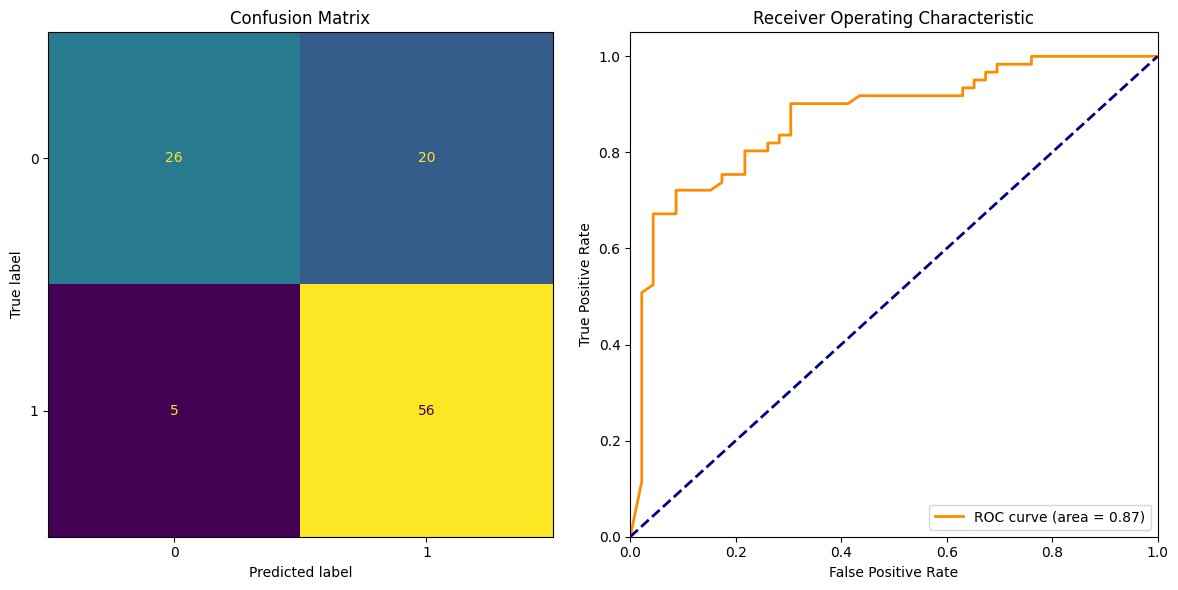

In [24]:
plot_classification_metrics(y_test, model1.predict_proba(X_test)[:, 1])

Accuracy: 0.75
Precision: 0.72
Recall: 0.90
F1 Score: 0.80
Specificity: 0.54


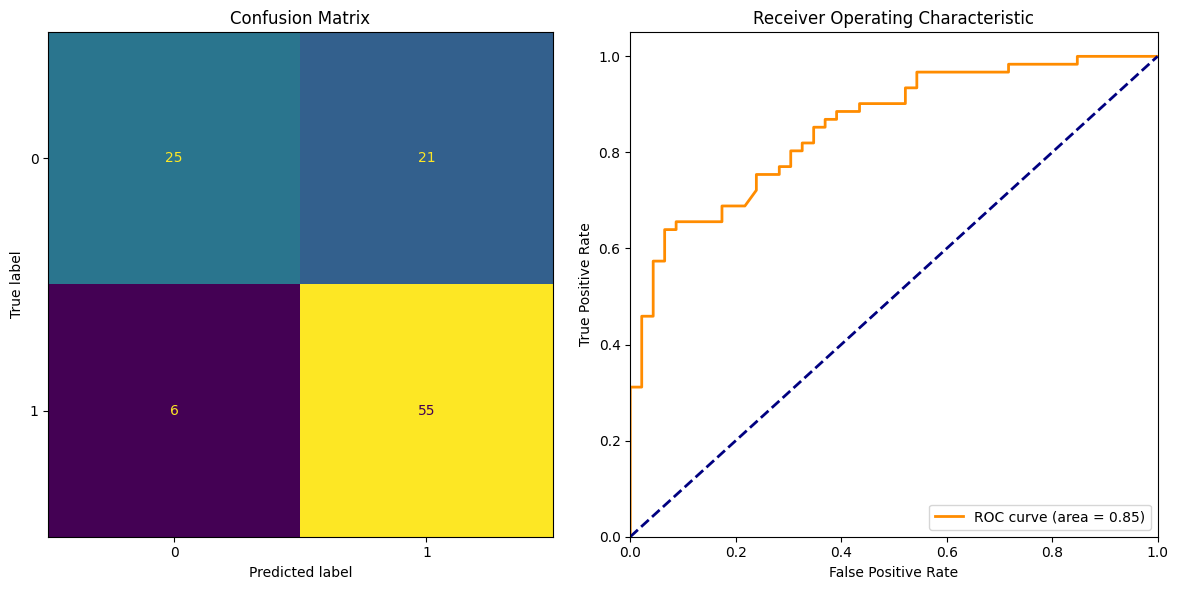

In [25]:
plot_classification_metrics(y_test, model2.predict_proba(X_test)[:, 1])

Accuracy: 0.74
Precision: 0.73
Recall: 0.85
F1 Score: 0.79
Specificity: 0.59


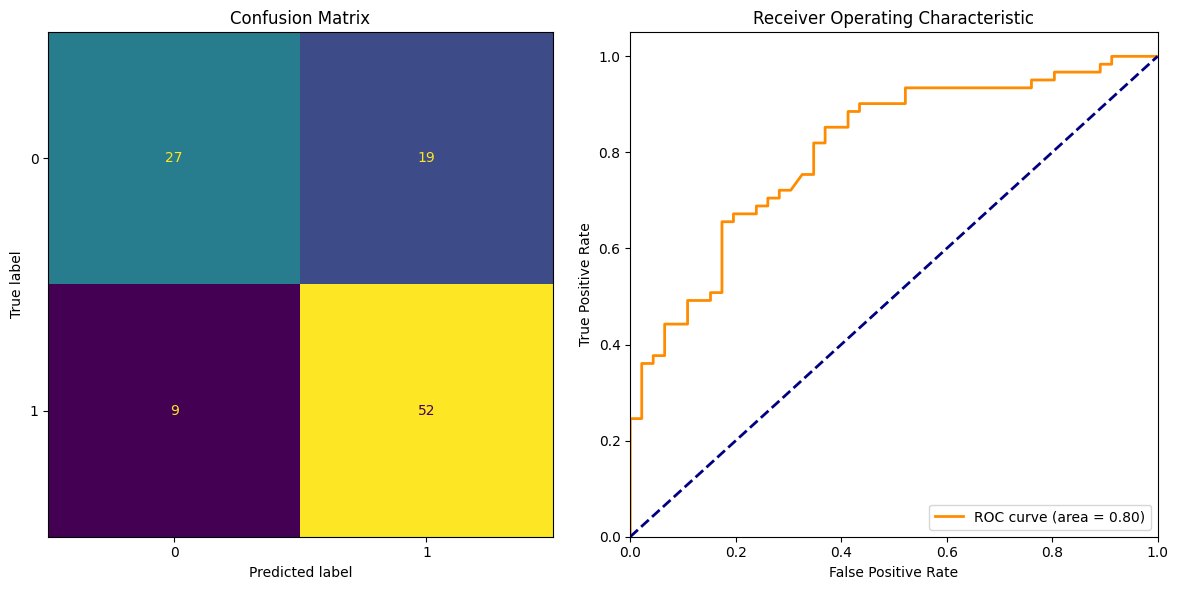

In [26]:
plot_classification_metrics(y_test, model3.predict_proba(X_test)[:, 1])

Accuracy: 0.74
Precision: 0.72
Recall: 0.89
F1 Score: 0.79
Specificity: 0.54


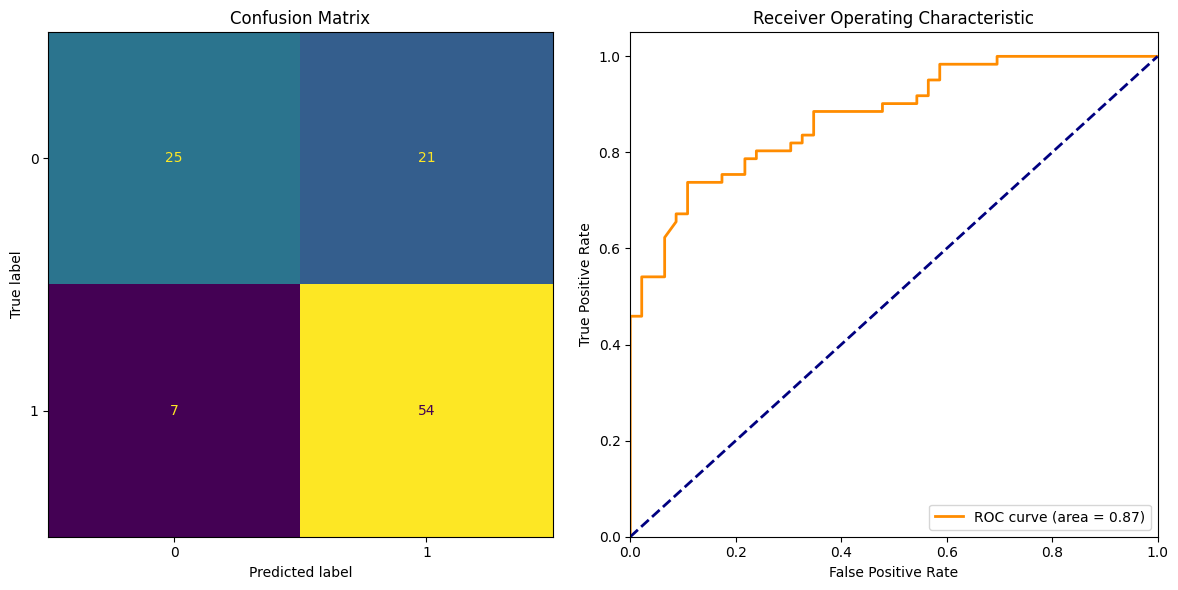

In [27]:
plot_classification_metrics(y_test, model4.predict_proba(X_test)[:, 1])

Accuracy: 0.99
Precision: 0.99
Recall: 1.00
F1 Score: 1.00
Specificity: 0.99


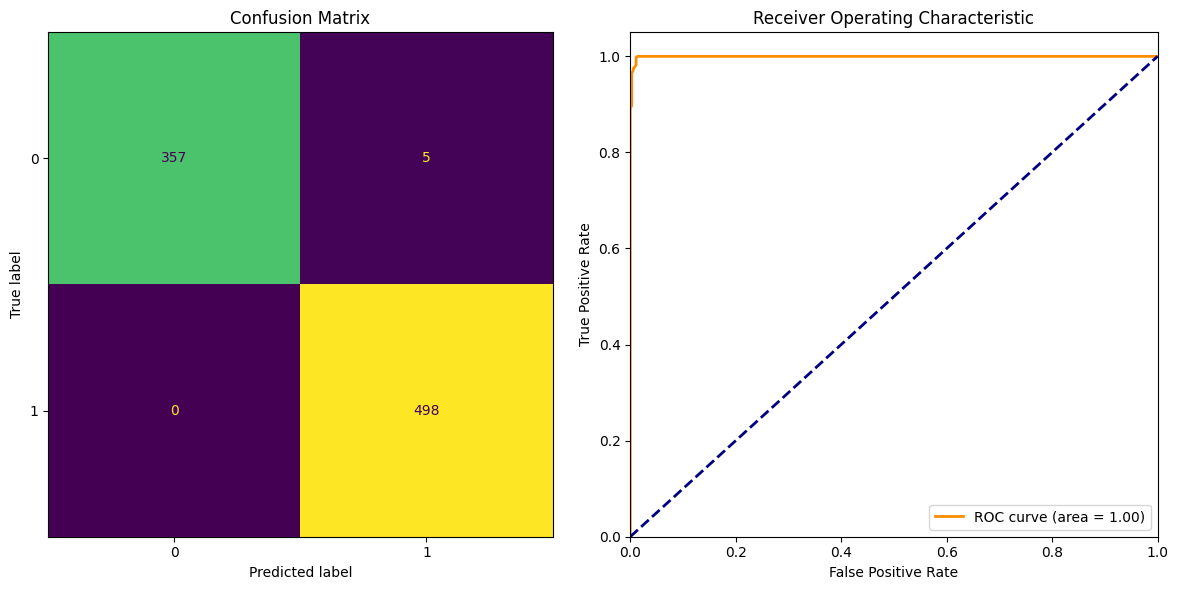

In [28]:
plot_classification_metrics(y_train, model1.predict_proba(X_train)[:, 1])

Accuracy: 0.93
Precision: 0.94
Recall: 0.93
F1 Score: 0.94
Specificity: 0.92


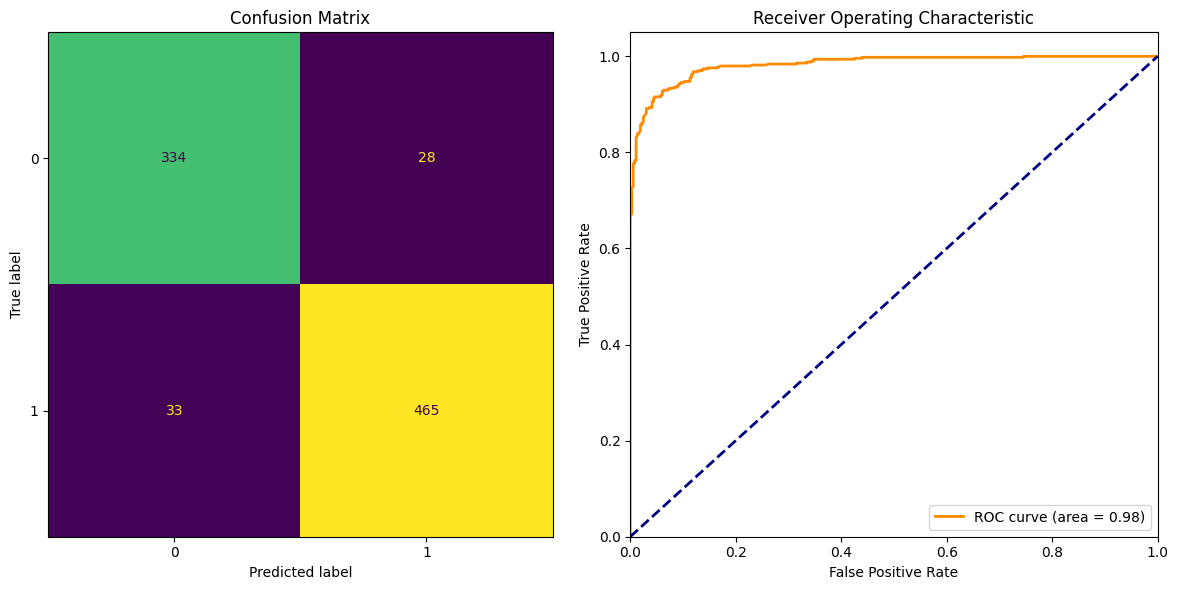

In [29]:
plot_classification_metrics(y_train, model2.predict_proba(X_train)[:, 1])

Accuracy: 0.89
Precision: 0.90
Recall: 0.90
F1 Score: 0.90
Specificity: 0.86


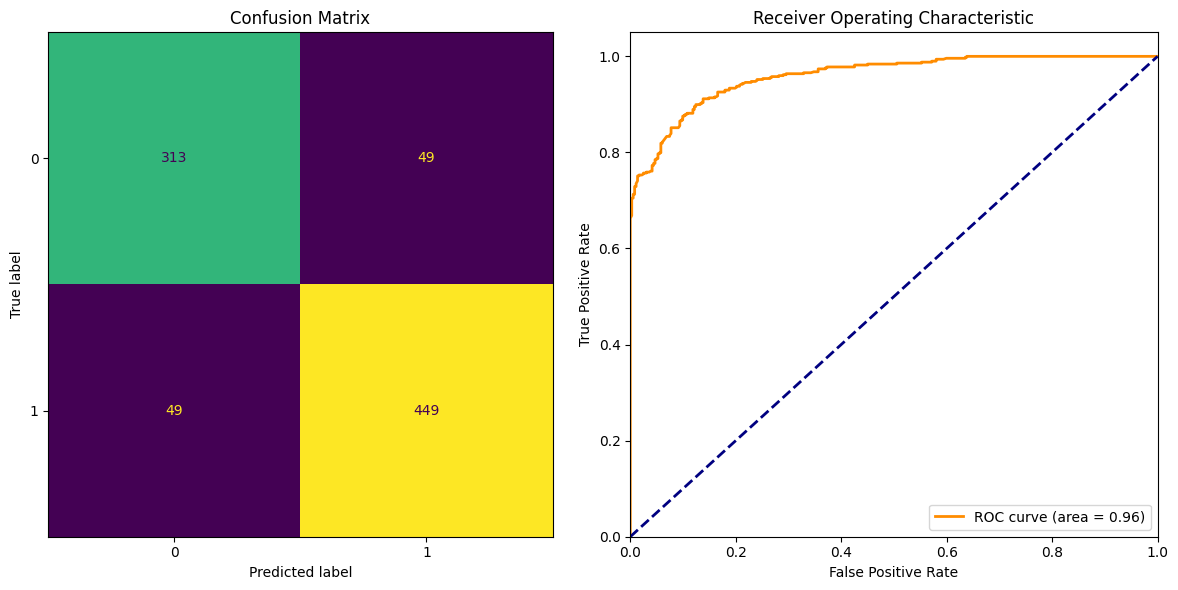

In [30]:
plot_classification_metrics(y_train, model3.predict_proba(X_train)[:, 1])

Accuracy: 0.99
Precision: 0.99
Recall: 1.00
F1 Score: 0.99
Specificity: 0.99


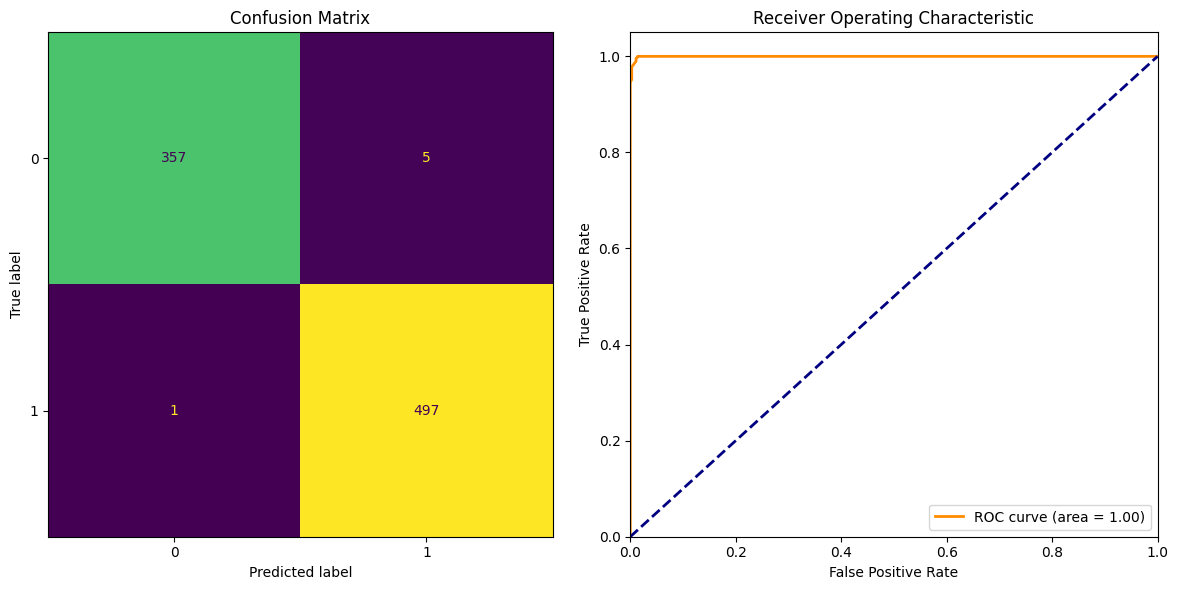

In [31]:
plot_classification_metrics(y_train, model4.predict_proba(X_train)[:, 1])

Accuracy: 0.79
Precision: 0.75
Recall: 0.87
F1 Score: 0.81
Specificity: 0.70


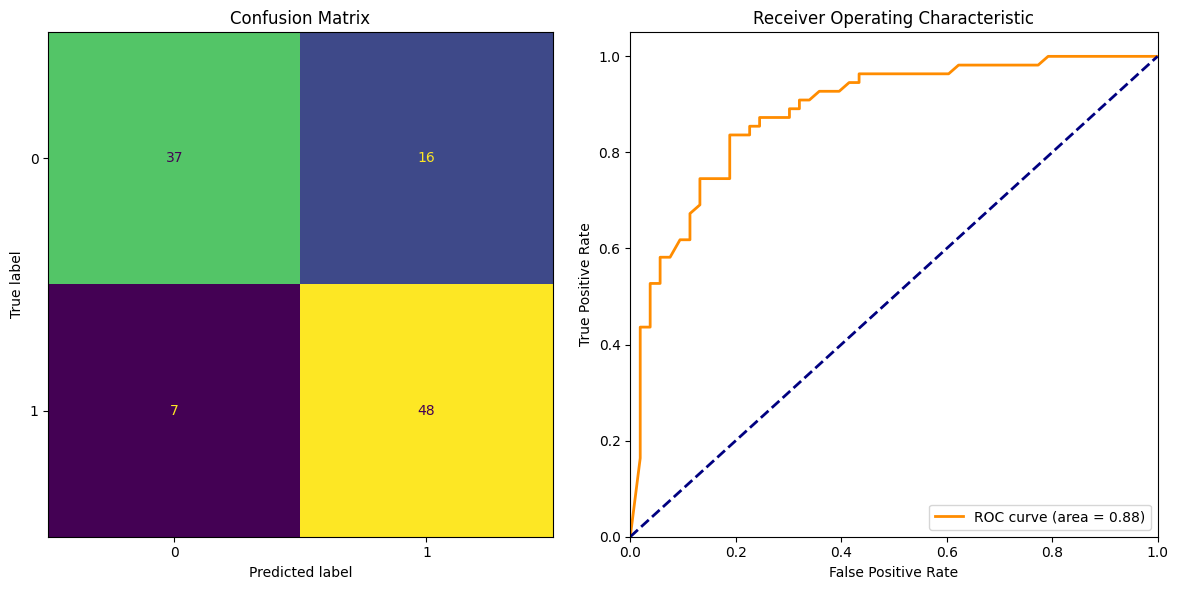

In [32]:
plot_classification_metrics(y_val, model1.predict_proba(X_val)[:, 1])

Accuracy: 0.80
Precision: 0.77
Recall: 0.85
F1 Score: 0.81
Specificity: 0.74


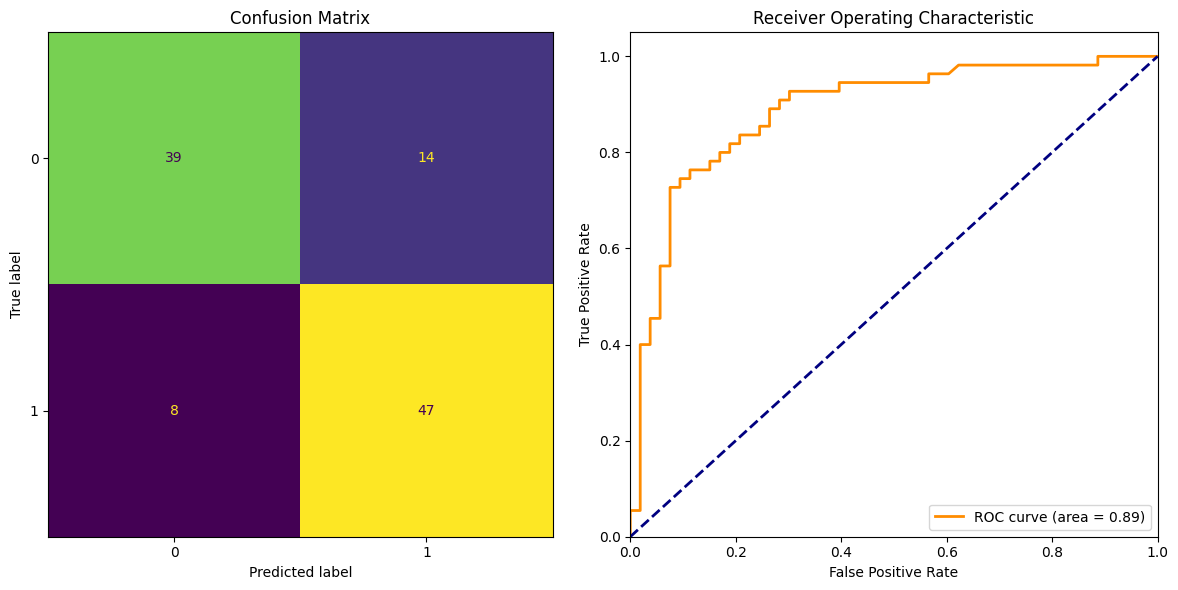

In [33]:
plot_classification_metrics(y_val, model2.predict_proba(X_val)[:, 1])

Accuracy: 0.80
Precision: 0.75
Recall: 0.89
F1 Score: 0.82
Specificity: 0.70


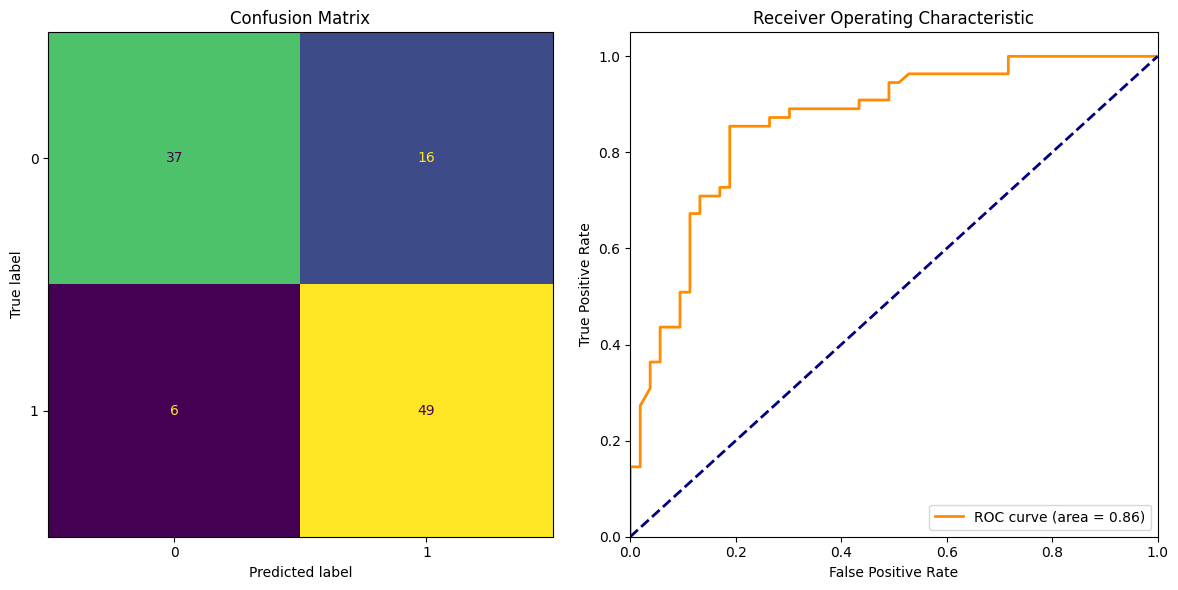

In [34]:
plot_classification_metrics(y_val, model3.predict_proba(X_val)[:, 1])

Accuracy: 0.79
Precision: 0.77
Recall: 0.84
F1 Score: 0.80
Specificity: 0.74


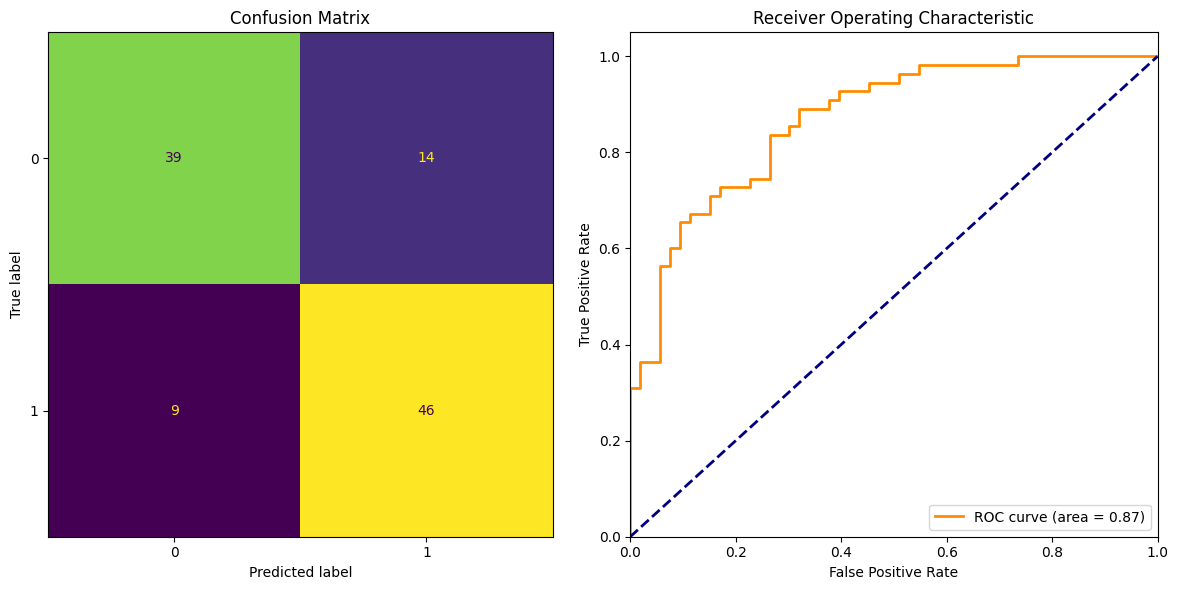

In [35]:
plot_classification_metrics(y_val, model4.predict_proba(X_val)[:, 1])